In [1]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [18]:
!rm -rf vgg16obj
!git clone https://github.com/soukhind2/vgg16obj


Cloning into 'vgg16obj'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 117 (delta 55), reused 56 (delta 23), pack-reused 0
Receiving objects: 100% (117/117), 1.18 MiB | 10.09 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [3]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class

In [4]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools





In [5]:
def convertimgs(path,data) :
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            data.append(im) 
    return data


train_it = []
train_it = convertimgs('/content/data_6class/train/faces/Male',train_it)
train_it = convertimgs('/content/data_6class/train/faces/Female/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Manmade/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Natural/',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Powered',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Nonpowered',train_it)
train_it = np.array(train_it)

val_it = []
val_it = convertimgs('/content/data_6class/val/faces/Male/',val_it)
val_it = convertimgs('/content/data_6class/val/faces/Female/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Manmade/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Natural/',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Powered',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Nonpowered',val_it)
val_it = np.array(val_it)

test_it = []
test_it = convertimgs('/content/data_6class/test/faces/Male/',test_it)
test_it = convertimgs('/content/data_6class/test/faces/Female/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Manmade/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Natural/',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Powered',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Nonowered',test_it)
test_it = np.array(test_it)

print(train_it.shape,val_it.shape,test_it.shape)


(1554, 224, 224, 3) (150, 224, 224, 3) (162, 224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

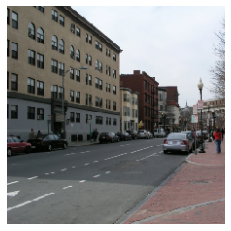

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train_it[700])
plt.axis('off')

In [7]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])
#plot_model(model,show_shapes=True,expand_nested=True)

58892288/58889256 [==============================] - 0s 0us/step


In [8]:
start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')

     
#np.save('features_train' , features_train)
#np.save('features_val', features_val)
#np.save('features_test', features_test)

Train Time: 15.178691148757935
Val Time: 1.8501620292663574
Test Time: 1.185373067855835


In [9]:
epochs = 30

#train_data = np.load('features_train.npy')
train_data = features_train
train_labels = to_categorical([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279,6)
train_labels1 = to_categorical([0] * 250 + [1]*250 + [0] * 250 + [1] * 250 + [0] * 275 + [1] * 279,2)
train_labels2 = to_categorical([0] * 250 + [0]*250 + [1] * 250 + [1] * 250 + [2] * 275 + [2] * 279,3)



#val_data = np.load('features_val.npy')
val_data = features_val
val_labels = to_categorical([0] * 25 + [1]*25 + [2] * 25 + [3] * 25 + [4] * 25 + [5] * 25,6)
val_labels1 = to_categorical([0] * 25 + [1]*25 + [0] * 25 + [1] * 25 + [0] * 25 + [1] * 25,2)
val_labels2 = to_categorical([0] * 25 + [0]*25 + [1] * 25 + [1] * 25 + [2] * 25 + [2] * 25,3)


#test_data = np.load('features_test.npy')
test_data = features_test
#test_labels = [0] * 50 + [1] * 50 + [2] * 50
#test_labels = [0] * 61 + [1] * 40 + [2] * 61
test_labels = to_categorical([0] * 31 + [1]*30 + [2] * 19 + [3] * 21 + [4] * 31 + [5] * 30,6)
test_labels1 = to_categorical([0] * 31 + [1]*30 + [0] * 19 + [1] * 21 + [0] * 31 + [1] * 30,2)
test_labels2 = to_categorical([0] * 31 + [0]*30 + [1] * 19 + [1] * 21 + [2] * 31 + [2] * 30,3)
#test_labels = to_categorical(test_labels, 3)


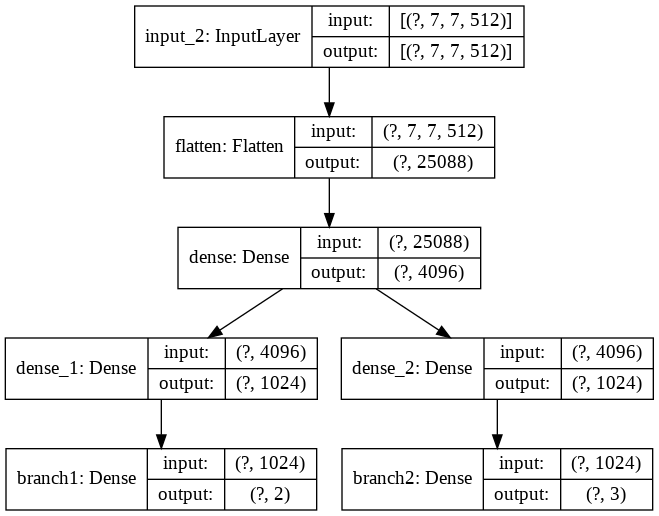

In [10]:
#@title Automated Branched Model Generation
from vgg16obj.tools import objnet

model = objnet.modelarch().build_full_model([7,7,512],
                                            stem_len = [4096],
                                            b1_len = [1024],
                                            b2_len = [1024])
plot_model(model,show_shapes=True,expand_nested=True)

In [11]:

model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(4096, activation='relu')) 
##model.add(Dropout(0.5)) 
model.add(Dense(4096, activation='relu')) 
model.add(Dense(6, activation='softmax'))
model.summary()

'''losses = {'branch1': 'binary_crossentropy',
          'branch2': 'categorical_crossentropy'}
'''
losses = 'categorical_crossentropy'

model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(x = train_data,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(val_data, val_labels),
          verbose = 1, callbacks = [es])

#model.save_weights('top_weights',overwrite = True)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 24582     
Total params: 119,570,438
Trainable params: 119,570,438
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
25/25 [==============================] - 1s 48ms/step - loss: 1.0416 - accuracy: 0.6577 - val_loss: 0.6080 - val_accuracy: 0.7533
Epoch 2/30
25/25 [==============================] - 1s 42ms/step - loss: 0.4030 - accuracy: 0.8578 

In [12]:
out = model.evaluate(test_data, test_labels)
print(out)

pred = model.predict(test_data)

#print('rounded test labels',pred)

6/6 [==============================] - 0s 6ms/step - loss: 0.3874 - accuracy: 0.8210
[0.38741445541381836, 0.8209876418113708]


In [13]:
#classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
#metric = metrics.classification_report(test_labels,pred,target_names = classes)
#print(metric)


In [ ]:
#@title Branch loss plotting code

lossNames = ["loss", "branch1_loss", "branch2_loss"]
plt.style.use("ggplot")
e = len(history.history['loss'])
(fig, ax) = plt.subplots(1, 3, figsize=(20, 5))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(np.arange(0, e), history.history[l], label=l)
	ax[i].plot(np.arange(0, e), history.history["val_" + l],
		label="validation_" + l)
	ax[i].legend()


Normalized confusion matrix


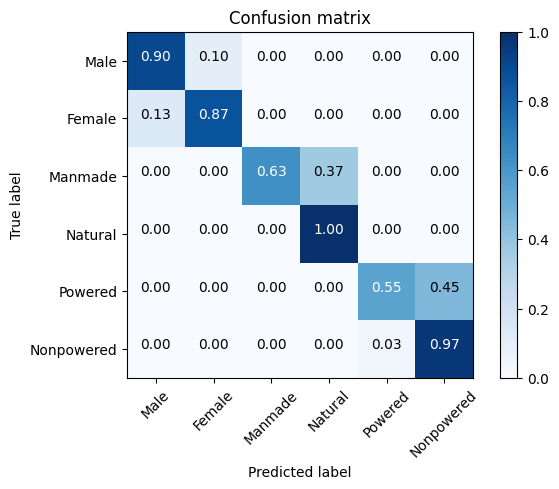

In [15]:
classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
#classes = ['Male/ Manmade/ Pwrd','Female/ Natural/ Nonpwrd']
#classes = ['Face', 'Scene','Tool']
plt.style.use('default')

from vgg16obj.tools import plot_tools as pt
#pt.plot_metrics(history)


categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)

pt.plot_confusion_matrix(cm,classes,normalize = True)

In [ ]:
plot_model(model,show_shapes=True,expand_nested=True)

Feature Map Extraction

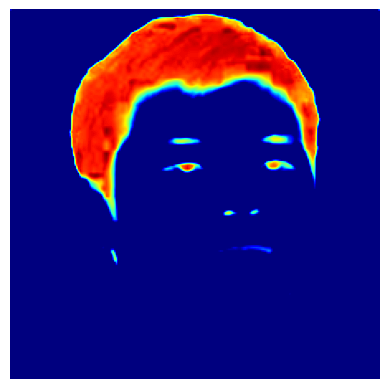

In [17]:
from keras import Model
img_tensor = train_it[0].reshape([1,224,224,3])

model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])

layer_outputs = [layer.output for layer in model.layers if 'conv1' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='jet')
plt.axis('off')
plt.show()


In [32]:
from vgg16obj.tools import tun_calc as tc

layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

start = time.time()
def calc_tun(data,activation_model,layer_names):
    tun_value = np.zeros((len(data),len(layer_names),600))
    for imgs,img_tensor in enumerate(data):
      img_tensor = img_tensor.reshape([1,224,224,3])
      intermediate_activations = activation_model.predict(img_tensor)
      for l in range(len(layer_names)):
        layer_activation = intermediate_activations[l]
        for k in range(layer_activation.shape[3]):
          tun_value[imgs,l,k] += np.mean(layer_activation[0,:,:,k])
          
    return tun_value

tun_value = calc_tun(train_it,activation_model,layer_names)
print(f'Elapsed: {time.time() - start}s')

np.save('tun_value' , tun_value)


Elapsed: 279.46498823165894s


In [78]:
tun_value = np.load('tun_value.npy')
fc = np.zeros((6,len(layer_names),600))
cat_tun = np.zeros((6,len(layer_names),600))
labels = np.array([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279)
avg_tun_value = np.mean(tun_value,0)
std_tun_value = np.std(tun_value,0)

for i in range(6):
  cat_tun[i] = np.mean(tun_value[np.where(labels == i)],0)

for category in range(6):
  for layer in range(fc.shape[0]):
    for map in range(fc.shape[1]):
      if cat_tun[category,layer,map] == 0 or avg_tun_value[layer,map] == 0 or std_tun_value[layer,map] == 0:
        continue
      fc[category,layer,map] = (cat_tun[category,layer,map] - 
                                avg_tun_value[layer,map])/std_tun_value[layer,map]
